# Template for ML training using the custom modules 

There are a few different modules that interact with each other to populate the datasets and carry out the training. This notebook shows the basic usage for these.

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-04-04 22:45:46.954529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 22:45:46.971721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 22:45:46.976939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## The steps for putting the data together
After filtering etc has already been done prior. 

### Setup main configuration parameters

This is on of the key steps, where much of the configuration for the machine learning model is setup. 

In [31]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'],  # What data sets to train on
                    'filter_scales':['50','100','200','400'], # What filter scales to train on
                    'window_size':1,  # What stencil we want to train on 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, inputs, outputs, 
                                          'dvdx_widened_rotated_nondim',  # including those used as coefficients (if you want to train y = coeff_var * ANN (x)
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # Note these non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], # And will require user to change SimulationData class if normalization needs changing
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  # Inputs to ANN
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim', # Outputs from ANN
                                          'vphp_rotated_nondim'],

                    'use_coeff_channels': False,
                    'coeff_channels'  : [],  # If any coefficients are used

                    'extra_channels'   : [  'uphp_rotated', # These are used during evaluation to go back to dimensional units. 
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    
                    'single_layer_mask': True, # A mask that says whether regions where only one dynamic layer is present should be masked out during training.

                    # The parameters below set how large the datasets need to be etc
                    'all_time_range': slice(0, 768),
                    'train_time_range': slice(0, 128*3),
                    'test_time_range' : slice(128*3, 128*4),
                    'eval_time_range' : slice(128*4, 128*5),
                    'num_train_batches': 3*8, # Each batch will have 16 snapshots
                    'num_test_batches' : 8, # Each batch will have 16 snapshots

                    #'num_inputs': 25*6, # Based on number of inputs and the stencil sizes
                    #'num_inputs': 9*6, # Based on number of inputs and the stencil sizes
                    'num_inputs': 1*6, # Based on number of inputs and the stencil sizes
                    'network_shape': [48, 48, 2], #Shape of network

                    # Set location where the ckpt will be saved
                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/template_trained/shape_48_48_2_window5/'
                    
            }


### SimulationData class

Reads in the simulations with the right type (DG, P2L etc), filter_scales, and over the chosen time ranges. Also:
- The window_size is used by this class to expand the data.
- Masking of data based on single_layer or thin layers is done here. (# could be made part of the next class)
- Variables that may have been missed during the data generation step can be added here.
- Variables are rotated as needed.
- Non-dimensionalization is done here

The object contains a datatree type, which has all these arranged together in xarray style. 

In [3]:
DT = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                             filter_scales=common_config['filter_scales'], 
                             window_size = common_config['window_size'], 
                             time_sel = common_config['all_time_range'],
                             single_layer_mask_flag=common_config['single_layer_mask']
                             )

In [4]:
DT.simulation_data # This is the attribute that carries the data. 

DataTree('None', parent=None)
├── DataTree('DG')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 768, xh: 200, yh: 218, zl: 2, Xn: 1,
│   │                                         Yn: 1, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
│   │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
│   │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/67)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           ...                           ...
│   │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           uphp_nondim                  (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           vphp_nondim                  (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           Rd_nondim                    (Time, yh, xh) float64 268MB dask.array<chunksize=(36, 218, 200), meta=np.ndarray>
│   │           single_layer_mask            (Time, yh, xh) float64 268MB dask.array<chunksize=(36, 218, 200), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 768, xh: 100, yh: 108, zl: 2, Xn: 1,
│   │                                         Yn: 1, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
│   │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
│   │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/67)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdy_widened  

A normalization dictionary is also initiated at this stage. 

#### Aside: How is widening done

```
ds.rolling(xh=self.window_size, yh=self.window_size, min_periods=1, center=True).construct(xh='Xn', yh='Yn')
```


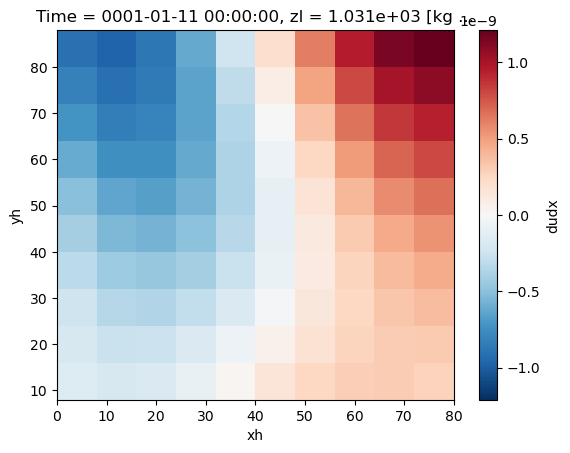

In [5]:
DT.simulation_data['P2L']['50'].dudx.isel(xh=slice(0,10), yh=slice(0,10), Time=0, zl=0).plot()

In [6]:
DT.simulation_data['P2L']['50'].dudx.isel(xh=slice(0,3), yh=slice(0,3), Time=0, zl=0)

<xarray.DataArray 'dudx' (yh: 3, xh: 3)> Size: 72B
dask.array<getitem, shape=(3, 3), dtype=float64, chunksize=(3, 3), chunktype=numpy.ndarray>
Coordinates:
    Time     object 8B 0001-01-11 00:00:00
  * xh       (xh) float64 24B 4.0 12.0 20.0
  * yh       (yh) float64 24B 12.0 20.0 28.0
    zl       float64 8B 1.031e+03

In [7]:
DT.simulation_data['P2L']['50'].dudx.isel(xh=slice(0,3), yh=slice(0,3), Time=0, zl=0).values

array([[-1.62795629e-10, -2.02495726e-10, -1.70727696e-10],
       [-1.98682168e-10, -2.65136755e-10, -2.56742639e-10],
       [-2.51995324e-10, -3.46330345e-10, -3.59945589e-10]])

In [8]:
DT.simulation_data['P2L']['50'].isel(xh=slice(0,3), yh=slice(0,3), Time=0, zl=0).xh.values

array([ 4., 12., 20.])

In [9]:
DT.simulation_data['P2L']['50'].isel(xh=slice(0,3), yh=slice(0,3), Time=0, zl=0).yh.values

array([12., 20., 28.])

In [10]:
for i in range(0,3): 
    for j in range(0,3): 
        print(i,j, 'x:', DT.simulation_data['P2L']['50'].isel(xh=i, yh=j, Time=0, zl=0).xh.values,
             ' y:', DT.simulation_data['P2L']['50'].isel(xh=i, yh=j, Time=0, zl=0).yh.values,
            DT.simulation_data['P2L']['50'].dudx.isel(xh=i, yh=j, Time=0, zl=0).values)

0 0 x: 4.0  y: 12.0 -1.6279562887471946e-10
0 1 x: 4.0  y: 20.0 -1.9868216849078375e-10
0 2 x: 4.0  y: 28.0 -2.5199532407369173e-10
1 0 x: 12.0  y: 12.0 -2.024957262456022e-10
1 1 x: 12.0  y: 20.0 -2.651367547503052e-10
1 2 x: 12.0  y: 28.0 -3.4633034487084636e-10
2 0 x: 20.0  y: 12.0 -1.7072769617659683e-10
2 1 x: 20.0  y: 20.0 -2.567426386809857e-10
2 2 x: 20.0  y: 28.0 -3.5994558931570893e-10


In [11]:
for i in range(0,common_config['window_size']):
    for j in range(0,common_config['window_size']): 
        print(i,j, 'x:', DT.simulation_data['P2L']['50'].isel(xh=i, yh=j, Time=0, zl=0).xh.values,
             ' y:', DT.simulation_data['P2L']['50'].isel(xh=i, yh=j, Time=0, zl=0).yh.values,
            DT.simulation_data['P2L']['50'].dudx_widened.isel(xh=1, yh=1, Time=0, zl=0, Xn=i, Yn=j).values)

0 0 x: 4.0  y: 12.0 -2.651367547503052e-10


In [12]:
for i in range(0,common_config['window_size']): 
    for j in range(0,common_config['window_size']): 
        print(i,j, 'x:', DT.simulation_data['P2L']['50'].isel(xh=i, yh=j, Time=0, zl=0).xh.values,
             ' y:', DT.simulation_data['P2L']['50'].isel(xh=i, yh=j, Time=0, zl=0).yh.values,
                DT.simulation_data['P2L']['50'].dudx_widened.isel(xh=1, yh=1, Time=0, zl=0, Xn=i, Yn=j).values)

0 0 x: 4.0  y: 12.0 -2.651367547503052e-10


### MLXarrayDataset class

This class does many tasks that help getting the data ready for actual machine learning. These include: 
- Choose what variables from simulation_data will actually be used for ML.
    - Select what all depths will be used for training.
- Sub-sample in time (e.g. to split into test, train etc)
- Sub-sample in space (e.g. to ensure that data with smaller filter scales don't artificially over-weight the data).
    - pick uniform number of points for data datatree node (further facilitating above task)
- Mask the data using thickness mask
- stack_physical dimensions
- drop any nans
- randomize data
- concat data from different experiments and filter scales
- randomize concatenated data
- generate batches

This class results in two useful attributes: `ml_dataset` and `ml_batches`. 

> Note that at the end of this class the data is still not in the X,y format needed for ML. Instead the different data variables are still in their xarray forms (but in terms of points). 

In [13]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=common_config['all_ml_variables'],
                                       time_range=common_config['train_time_range'],
                                       num_batches = common_config['num_train_batches'],
                                       choose_experiment=common_config['simulation_names'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=common_config['all_ml_variables'],
                                       time_range=common_config['test_time_range'],
                                       num_batches = common_config['num_test_batches'],
                                       choose_experiment=common_config['simulation_names'])

Will load : 0.31988736 gb into memory.
load took: 21.0082 seconds
Will load : 0.10662912 gb into memory.
load took: 9.7193 seconds


In [14]:
ML_DT_train.ml_dataset

DataTree('None', parent=None)
├── DataTree('DG')
│   ├── DataTree('50')
│   │       Dimensions:                      (Xn: 1, Yn: 1, points: 207360)
│   │       Coordinates:
│   │         * points                       (points) object 2MB MultiIndex
│   │         * Time                         (points) object 2MB 0011-04-29 00:00:00 ... ...
│   │         * xh                           (points) float64 2MB 16.77 14.13 ... 16.77
│   │         * yh                           (points) float64 2MB 37.41 39.59 ... 43.23
│   │         * zl                           (points) float64 2MB 1.036e+03 ... 1.036e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables:
│   │           dudx_widened_rotated_nondim  (Xn, Yn, points) float64 2MB 0.5546 ... -0.4071
│   │           dvdx_widened_rotated_nondim  (Xn, Yn, points) float64 2MB -0.635 ... 0.8064
│   │           dudy_widened_rotated_nondim  (Xn, Yn, points) float64 2MB 0.02062 ... -0....
│   │           dvdy_widened_rotated_nondim  (Xn, Yn, points) float64 2MB -0.5374 ... 0.3984
│   │           dhdx_widened_rotated_nondim  (Xn, Yn, points) float64 2MB 1.0 1.0 ... 1.0
│   │           dhdy_widened_rotated_nondim  (Xn, Yn, points) float64 2MB 0.0 ... -6.288e-17
│   │           uphp_rotated_nondim          (points) float64 2MB 0.04248 ... -0.03439
│   │           vphp_rotated_nondim          (points) float64 2MB -0.05498 ... 0.0732
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Xn: 1, Yn: 1, points: 207360)
│   │       Coordinates:
│   │         * points                       (points) object 2MB MultiIndex
│   │         * Time                         (points) object 2MB 0002-11-02 00:00:00 ... ...
│   │         * xh                           (points) float64 2MB 10.67 9.79 ... 16.83 17.71
│   │         * yh                           (points) float64 2MB 45.55 36.09 ... 33.18
│   │         * zl                           (points) float64 2MB 1.036e+03 ... 1.036e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables:
│   │           dudx_widened_rotated_nondim  (Xn, Yn, points) float64 2MB -0.003709 ... -...
│   │           dvdx_widened_rotated_nondim  (Xn, Yn, points) float64 2MB -0.1476 ... 0.4584
│   │           dudy_widened_rotated_nondim  (Xn, Yn, points) float64 2MB 0.989 ... -0.09891
│   │           dvdy_widened_rotated_nondim  (Xn, Yn, points) float64 2MB 0.005815 ... 0....
│   │           dhdx_widened_rotated_nondim  (Xn, Yn, points) float64 2MB 1.0 1.0 ... 1.0
│   │           dhdy_widened_rotated_nondim  (Xn, Yn, points) float64 2MB -1.602e-17 ... 0.0
│   │           uphp_rotated_nondim          (points) float64 2MB -0.01542 ... -0.05956
│   │           vphp_rotated_nondim          (points) float64 2MB -0.009076 ... 0.05851
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     100
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 100 km resolution
│   ├── DataTree('200')
│   │       Dimensions:                      (Xn: 1, Yn: 1, points: 207360)
│   │       Coordinates:
│   │         * points                       (points) object 2MB MultiIndex
│   │         * Time                         (points) object 2MB 0004-09-12 00:00:00 ... ...
│   │         * xh                           (points) float64 2MB 7.26 3.74 ... 12.54 17.82
│   │         * yh                           (points) float64 2MB 32.73 36.36 ... 32.0 35.64
│   │         * zl                           (points) float64 2MB 1.035e+03 ... 1.035e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables:
│   │           dud

In [15]:
ML_DT_train.ml_batches[0]

<xarray.Dataset> Size: 7MB
Dimensions:                      (Xn: 1, Yn: 1, points: 69120)
Coordinates:
  * points                       (points) object 553kB MultiIndex
  * Time                         (points) object 553kB 0011-03-30 00:00:00 .....
  * xh                           (points) float64 553kB 11.0 40.0 ... 740.0 11.0
  * yh                           (points) float64 553kB 31.82 760.0 ... 42.0
  * zl                           (points) float64 553kB 1.036e+03 ... 1.035e+03
Dimensions without coordinates: Xn, Yn
Data variables:
    dudx_widened_rotated_nondim  (Xn, Yn, points) float64 553kB 0.2783 ... 0....
    dvdx_widened_rotated_nondim  (Xn, Yn, points) float64 553kB -0.7109 ... -...
    dudy_widened_rotated_nondim  (Xn, Yn, points) float64 553kB 0.6091 ... 0....
    dvdy_widened_rotated_nondim  (Xn, Yn, points) float64 553kB -0.2149 ... -...
    dhdx_widened_rotated_nondim  (Xn, Yn, points) float64 553kB 1.0 1.0 ... 1.0
    dhdy_widened_rotated_nondim  (Xn, Yn, points) float64 553kB 0.0 ... -1.07...
    uphp_rotated_nondim          (points) float64 553kB 0.011 ... 0.02248
    vphp_rotated_nondim          (points) float64 553kB -0.08493 ... 0.0128
Attributes:
    simulation_name:  DG
    filter_scale:     50
    source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
    description:      Dataset for DG experiment at 50 km resolution

### MLJAXDataset Class 

The above batches are still not in a form that is ingestible into a ML library, so steps need to taken to do that. The purpose of this library is to stack inputs in vectors X and Y, and also put the data into a format that Jax understands. 


- **Normalize the input and output data (and also coeff_variables)**, using the ds_norm dictionary. 
- Stacks the input variables and the data from the stencil into one long vector (`input_features`, `points`), and the output variables into a (`variables`, `points`) form.
- Converts to jax array.
- If there are any coefficient vatiables, then multiple them all together to get `output = coeff * y_o`.
- 

> The prepocess_batch function is the important one, which lays out the processes of this class. 

In [16]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=common_config['input_channels'], 
                                      output_channels=common_config['output_channels'], 
                                      coeff_channels=common_config['coeff_channels'], 
                                      use_coeff_channels=common_config['use_coeff_channels'],
                                      do_normalize=True)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=common_config['input_channels'], 
                                      output_channels=common_config['output_channels'], 
                                      coeff_channels=common_config['coeff_channels'], 
                                      use_coeff_channels=common_config['use_coeff_channels'],
                                      do_normalize=True)

In [17]:
train_ML_data.preprocessed_data[0]

{'X': Array([[ 2.7827385e-01, -7.1087164e-01,  6.0912657e-01, -2.1491848e-01,
          1.0000000e+00,  0.0000000e+00],
        [-2.3388932e-02, -9.9709964e-01,  6.7939028e-02,  2.5091548e-02,
          1.0000000e+00,  0.0000000e+00],
        [-4.8638448e-01, -2.1610004e-01,  6.8741137e-01,  4.9416244e-01,
          1.0000000e+00,  0.0000000e+00],
        ...,
        [ 1.9952519e-01, -9.3858695e-01,  1.9471553e-01, -2.0329799e-01,
          1.0000000e+00,  0.0000000e+00],
        [-5.3379011e-01, -5.3154111e-01,  1.4886761e-01,  6.4060169e-01,
          1.0000000e+00,  0.0000000e+00],
        [ 5.0705940e-01, -4.7564673e-01,  5.5411202e-01, -4.5783275e-01,
          1.0000000e+00, -1.0727619e-17]], dtype=float32),
 'y': Array([[ 0.11004271, -0.84928757],
        [-0.07690348, -0.5643521 ],
        [-0.6163769 , -0.19504784],
        ...,
        [ 0.24191843, -1.2644633 ],
        [-0.6307378 , -1.4894965 ],
        [ 0.22480176,  0.12804781]], dtype=float32),
 'Xp': Array([[1., 1.],


In [18]:
train_ML_data.preprocessed_data[0]['X'].shape

(69120, 6)

In [19]:
train_ML_data.ds_norm[common_config['all_ml_variables']]

<xarray.Dataset> Size: 64B
Dimensions:                      ()
Data variables:
    dudx_widened_rotated_nondim  float64 8B 1.0
    dvdx_widened_rotated_nondim  float64 8B 1.0
    dudy_widened_rotated_nondim  float64 8B 1.0
    dvdy_widened_rotated_nondim  float64 8B 1.0
    dhdx_widened_rotated_nondim  float64 8B 1.0
    dhdy_widened_rotated_nondim  float64 8B 1.0
    uphp_rotated_nondim          float64 8B 0.1
    vphp_rotated_nondim          float64 8B 0.1

In [20]:
# We combine the test and train data as this single dictionary just for convenience. 
ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

#### Aside on ordering of X and y 

It is important to recognize the way the ordering of the original variables is done into X and y, since we need to manually code this when implementing. 

In [21]:
# Internally the step that is done to stack the data is the following: 
stacked_X_samples = (ML_DT_train.ml_batches[0][common_config['input_channels']]/ML_DT_train.ds_norm).isel(points=slice(0,2)).to_stacked_array("input_features", sample_dims=['points'])
stacked_y_samples = (ML_DT_train.ml_batches[0][common_config['output_channels']]/ML_DT_train.ds_norm).isel(points=slice(0,2)).to_array().transpose(..., 'variable')

In [22]:
stacked_y_samples

<xarray.DataArray (points: 2, variable: 2)> Size: 32B
array([[ 0.11004271, -0.84928758],
       [-0.07690347, -0.56435207]])
Coordinates:
  * points    (points) object 16B MultiIndex
  * Time      (points) object 16B 0011-03-30 00:00:00 0008-09-11 00:00:00
  * xh        (points) float64 16B 11.0 40.0
  * yh        (points) float64 16B 31.82 760.0
  * zl        (points) float64 16B 1.036e+03 1.031e+03
  * variable  (variable) object 16B 'uphp_rotated_nondim' 'vphp_rotated_nondim'

In [23]:
stacked_X_samples[0] #<- the input_features object has the ordering of how the variables are arranged into X. 

<xarray.DataArray 'dudx_widened_rotated_nondim' (input_features: 6)> Size: 48B
array([ 0.27827384, -0.71087166,  0.60912658, -0.21491849,  1.        ,
        0.        ])
Coordinates:
    points          object 8B (cftime.DatetimeJulian(11, 3, 30, 0, 0, 0, 0, h...
    Time            object 8B 0011-03-30 00:00:00
    xh              float64 8B 11.0
    yh              float64 8B 31.82
    zl              float64 8B 1.036e+03
  * input_features  (input_features) object 48B MultiIndex
  * variable        (input_features) <U27 648B 'dudx_widened_rotated_nondim' ...
  * Xn              (input_features) int64 48B 0 0 0 0 0 0
  * Yn              (input_features) int64 48B 0 0 0 0 0 0

In [24]:
train_ML_data.preprocessed_data[0]['X'][0]

Array([ 0.27827385, -0.71087164,  0.60912657, -0.21491848,  1.        ,
        0.        ], dtype=float32)

In [25]:
train_ML_data.preprocessed_data[0]['y'][0]

Array([ 0.11004271, -0.84928757], dtype=float32)

In [26]:
stacked_X_samples[0].input_features

<xarray.DataArray 'input_features' (input_features: 6)> Size: 48B
array([('dudx_widened_rotated_nondim', 0, 0),
       ('dvdx_widened_rotated_nondim', 0, 0),
       ('dudy_widened_rotated_nondim', 0, 0),
       ('dvdy_widened_rotated_nondim', 0, 0),
       ('dhdx_widened_rotated_nondim', 0, 0),
       ('dhdy_widened_rotated_nondim', 0, 0)], dtype=object)
Coordinates:
    points          object 8B (cftime.DatetimeJulian(11, 3, 30, 0, 0, 0, 0, h...
    Time            object 8B 0011-03-30 00:00:00
    xh              float64 8B 11.0
    yh              float64 8B 31.82
    zl              float64 8B 1.036e+03
  * input_features  (input_features) object 48B MultiIndex
  * variable        (input_features) <U27 648B 'dudx_widened_rotated_nondim' ...
  * Xn              (input_features) int64 48B 0 0 0 0 0 0
  * Yn              (input_features) int64 48B 0 0 0 0 0 0

Just double check above that the numbers are the same, to ensure that we actually know the right ordering. 

## The steps for training the model

- Setup ANN
    - This is where inputs
    - Network shape
    - some random key is assigned.
- Setup regress system
    - This is where loss_type etc are defined.
- Train the model. 

In [32]:
ANN_model = ML_classes.PointwiseANN(num_in = common_config['num_inputs'],
                                        shape  = common_config['network_shape'],
                                        random_key=1) 

In [33]:
print('Num parameters to train ' + str(ANN_model.count_parameters()))

Num parameters to train 2786


In [34]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model, loss_type='mae')

In [35]:
regress_sys.train_system(ML_data_combo, num_epoch=501, print_freq=20, min_relative_improvement=1e-3)

At epoch 1. Train loss :  0.46621813376744586 , Test loss: 0.46633441373705864 , Test R2: -0.786568209528923
Early stopping at epoch 12. No improvement in 10 epochs.
Restored best model with smoothed test loss 0.463996


In [31]:
regress_sys.test_loss

array([0.2183187 , 0.19767222, 0.18809235, 0.17850015, 0.17586347,
       0.16933442, 0.16677735, 0.16288886, 0.161583  , 0.16490685,
       0.15711415, 0.15637675, 0.15501734, 0.15606647, 0.15333156,
       0.15165659, 0.15241298, 0.15170933, 0.15105387, 0.14825069,
       0.14849715, 0.1492314 , 0.14863278, 0.149174  , 0.15123419,
       0.14532321, 0.14608741, 0.14630575, 0.14812611, 0.14335436,
       0.14376014, 0.14314849, 0.14188517, 0.14219919, 0.14481364,
       0.14248639, 0.14176064, 0.14211917, 0.13997981, 0.14127399,
       0.14109937, 0.14050637, 0.1414777 , 0.13976091, 0.13934675,
       0.14009383, 0.1411653 , 0.13881352, 0.1395551 , 0.13788866,
       0.13826987, 0.13888509, 0.13780185, 0.14135845, 0.13822497,
       0.13746114, 0.13615203, 0.13795986, 0.13853955, 0.13761917,
       0.13585643, 0.13713563, 0.13788374, 0.13542215, 0.13547324,
       0.13513486, 0.13701142, 0.13798464, 0.13463326, 0.13713045,
       0.13559187, 0.13472327, 0.13643604, 0.13498871, 0.13466

In [35]:
regress_sys.network.params

{'params': {'layers_0': {'kernel': Array([[-0.03420822,  0.00376185,  0.03551653, ..., -0.06608523,
           -0.02688145,  0.06209525],
          [-0.10986309, -0.03954262,  0.11064824, ..., -0.04134551,
           -0.03017359, -0.11796463],
          [ 0.00943249, -0.13324009, -0.09722354, ...,  0.02232381,
            0.04001304, -0.07942711],
          ...,
          [-0.02699815,  0.12022541, -0.1393928 , ..., -0.10584536,
           -0.05126502,  0.07939722],
          [-0.13163957,  0.01130599, -0.01885917, ..., -0.0263985 ,
           -0.01179165, -0.0200485 ],
          [ 0.00899728,  0.02891855,  0.05937758, ...,  0.08719126,
           -0.03766432, -0.09904598]], dtype=float32),
   'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)},
  'layers_1': {'kernel': Array([[-0.06216426,  

#### Saving the model

In [32]:
# Save as checkpoint file
regress_sys.save_checkpoint(common_config['ckpt_save_dir'])

In [33]:
# Save weights and some other information as netcdf file 
regress_sys.save_nc(nc_fname = 'test_window5.nc', 
                    ML_DT_train=ML_DT_train, 
                    input_channels = common_config['input_channels'],
                    output_channels = common_config['output_channels'],
                    ckpt_save_dir = common_config['ckpt_save_dir'])

In [34]:
regress_sys.ds_layers # if you want to see what was in the netcdf file that was saved. 

<xarray.Dataset> Size: 41kB
Dimensions:       (num_layers: 4, layer_0: 150, layer_1: 48, layer_2: 48,
                   layer_3: 2, epochs: 130)
Dimensions without coordinates: num_layers, layer_0, layer_1, layer_2, layer_3,
                                epochs
Data variables:
    layer_sizes   (num_layers) int32 16B 150 48 48 2
    A0            (layer_0, layer_1) float32 29kB 0.08216 -0.0286 ... -0.06157
    b0            (layer_1) float32 192B -0.04242 -0.04439 ... 0.1539 -0.1103
    A1            (layer_1, layer_2) float32 9kB 0.04948 0.6906 ... 0.5741
    b1            (layer_2) float32 192B -0.08753 -0.1662 ... -0.0961 -0.1679
    A2            (layer_2, layer_3) float32 384B -0.364 -0.3998 ... 0.3022
    b2            (layer_3) float32 8B -0.0003044 0.03122
    input_norms   (layer_0) float32 600B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    output_norms  (layer_3) float32 8B 0.004 0.004
    test_loss     (epochs) float64 1kB 0.2183 0.1977 0.1881 ... 0.1341 0.1306
    test_R2       (epochs) float64 1kB 0.1027 0.1919 0.236 ... 0.5254 0.5358
Attributes:
    CKPT_DIR:         /home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints...
    shape:            [48, 48, 2]
    num_in:           150
    input_channels:   ['dudx_widened_rotated_nondim', 'dvdx_widened_rotated_n...
    output_channels:  ['uphp_rotated_nondim', 'vphp_rotated_nondim']